# 2022-07-26 • Multiseed

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

Based on Roxin; same as previous nb's.

In [7]:
d = 6
ps = [
     get_params(
        duration = 10minutes,
        p_conn = 0.04,
        g_EE = 1   / d,
        g_EI = 18  / d,
        g_IE = 36  / d,
        g_II = 31  / d,
        ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
        E_inh = -80 * mV,
        record_v = [1:40; 801:810;];
        rngseed,
    )
    for rngseed in [VoltoMapSim.default_rngseed, 0]
];

## Run sim

In [8]:
ss = [cached(sim, [p.sim]) for p in ps];

In [9]:
ss = [augment_simdata(s, p) for (s,p) in zip(ss,ps)];

## Eval conntest perf for all v recorded

In [10]:
recorded = p[1].sim.network.record_v;

In [11]:
# using Base.Threads

In [14]:
detrates = [Dict(), Dict()]

for i in [1,2]
    # @threads for m in recorded
    for m in recorded
        ii = get_input_info(m, ss[i], ps[i]);
        perf = cached(evaluate_conntest_perf, [ii.v, ii.spiketrains, ps[i]], key=[ps[i], m])
        detrates[i][m] = perf.detection_rates
    end
end;

## Plot distributions

In [20]:
using PyPlot

In [21]:
using VoltoMapSim.Plot

In [22]:
exc_rec = [1:40;]
inh_rec = [801:810;];

In [27]:
ydistplot = VoltoMapSim.Plot.ydistplot;

In [73]:
function detplot(coll, name)
    N = length(coll)
    fill = " "^17
    ax = ydistplot(
        fill*"Exc. inputs" => [detrates[1][n].TPR_exc for n in coll],
        ""                 => [detrates[2][n].TPR_exc for n in coll],
        fill*"Inh. inputs" => [detrates[1][n].TPR_inh for n in coll],
        ""                 => [detrates[2][n].TPR_inh for n in coll],
        fill*"Unconn." => [detrates[1][n].FPR for n in coll],
        ""             => [detrates[2][n].FPR for n in coll],
        xpos = [1.2, 1.8,  3.2, 3.8,  5.2, 5.8],
        figsize = (6,3),
        ylim = [0,1],
        hylabel = ("Detection rates for $(name) neurons (n = $N)\n"
            * "for two different network initializations (left–right)"
        ),
    )
    add_α_line(ax, p[1].evaluation.α)
    return nothing
end;

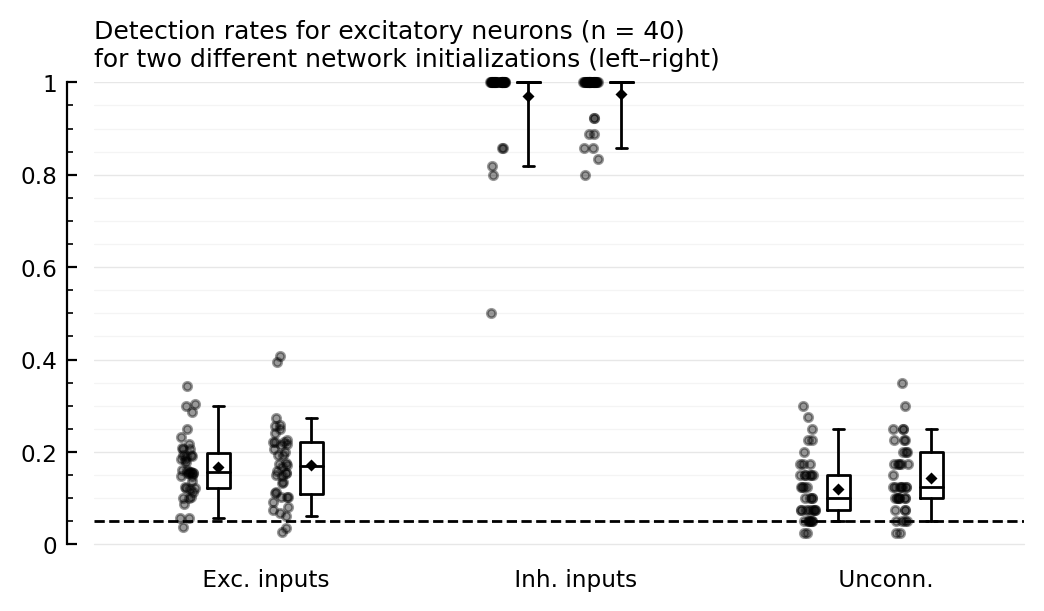

In [74]:
detplot(exc_rec, "excitatory")

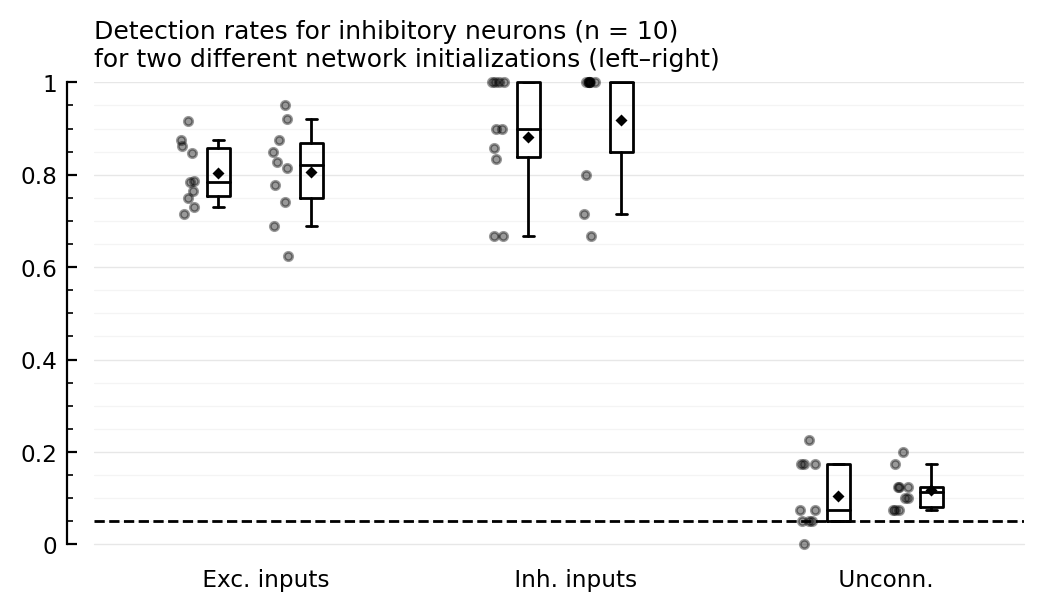

In [75]:
detplot(inh_rec, "inhibitory")